<a href="https://colab.research.google.com/github/johnli100/Sentiment_Analysis_RNN_Pretrained_embedding/blob/main/Sentiment_Analysis_using_RNN_with_pre_trained_embeddings_in_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchtext
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
cuda=torch.cuda.is_available()
print(cuda)

True


In [3]:
!pip install contractions
!pip install symspellpy
!pip install inflect

In [4]:
# text pre-processing
# inputs: 
#   remove html tags, urls
#   remove punctuations
#   converting numbers to corresponding words e.g. 123 to one hundred twenty-three
#   convert to lowercase
#   fix contractions e.g. gotta to got to, haven't to have not
#   remove stopword e.g. the, a, i
#   spelling correction NOTE this takes about 1 second for every 200-300 words paragraph
#   convert to stemming word e.g. surprise to surpr
#   lemmatize verbs e.g. walked, walking to walk
# outputs:
#   processed sentence
import re
import contractions
from string import punctuation
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
import inflect
import pkg_resources
from symspellpy import SymSpell, Verbosity
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = pkg_resources.resource_filename("symspellpy", "frequency_dictionary_en_82_765.txt")
bigram_path = pkg_resources.resource_filename("symspellpy", "frequency_bigramdictionary_en_243_342.txt")
# term_index is the column of the term and count_index is the column of the term frequency
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)


def preprocess(sentence,html=True,lower=True,contraction=True,punctuation=True,convert_number=True,stopword=False,spelling=False,lemmatize=False,stem=False):
  
  # remove html tags, url
  if html == True:
    sentence = re.sub(r'<.*?>',' ',sentence)
    sentence = re.sub(r'http\S+',' ',sentence)

  # conver to lowercases
  if lower == True:
    sentence = sentence.lower()

  # fix contractions e.g. gotta to got to 
  if contraction == True:
    sentence = contractions.fix(sentence)

  # remove punctuations
  if punctuation == True:
    #sentence = re.sub(r'[\!\"\#\$\%\&\\\'\(\)\*\+\,\-\.\/\:\;\<\=\>\?\@\[\\\\\]\^\_\`\{\|\}\~]',' ',sentence)
    sentence = re.sub(r'[\!\"\#\$\%\&\\\(\)\*\+\,\-\.\:\;\<\=\>\?\@\[\\\\\]\^\_\`\{\|\}\~]',' ',sentence)

  # convert numbers into corresponding words
  if convert_number == True:
    p=inflect.engine()
    sentence_converted = []
    for w in sentence.split():
      if w.isdigit():
        sentence_converted.append(p.number_to_words(w))
      else:
        sentence_converted.append(w)
    sentence = ' '.join(sentence_converted)

  # remove stopwords e.g. the, a, i etc.
  if stopword == True:
    sentence = ' '.join([w for w in sentence.split() if w not in stopwords.words('english')])  

  # spelling correction
  if spelling == True:
    # lookup suggestions for multi-word input strings (supports compound splitting & merging)
    # max edit distance per lookup (per single word, not per whole input string)
    corrected = sym_spell.lookup_compound(sentence, max_edit_distance=1)
    sentence = ' '.join([str(w) for w in corrected])

  # lemmatize e.g. walking, walked to walk  
  if lemmatize == True:
    lemmatizer = WordNetLemmatizer()
    sentence = ' '.join([lemmatizer.lemmatize(w) for w in sentence.split()])

  # convert into stemming word e.g. surprise to surpr
  if stem == True:
    stemmer = LancasterStemmer()
    sentence = ' '.join([stemmer.stem(w) for w in sentence.split()])

  return sentence


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
train_data_raw,test_data_raw=torchtext.datasets.IMDB(root='.data', split=('train', 'test'))

In [6]:
train_label=[]
train_review_raw=[]
for l, t in train_data_raw:
  train_label.append(l)
  train_review_raw.append(t)  
test_label=[]
test_review_raw=[]
for l, t in test_data_raw:
  test_label.append(l)
  test_review_raw.append(t)  

In [7]:
train_y=np.array([0 if l=='neg' else 1 for l in train_label])
test_y=np.array([0 if l=='neg' else 1 for l in test_label])

In [8]:
# pre-process reviews
import timeit
starttime = timeit.default_timer()
print("The start time is :",starttime)
train_review=[preprocess(r) for r in train_review_raw]
test_review=[preprocess(r) for r in test_review_raw]
print("The time difference is :", timeit.default_timer() - starttime)

The start time is : 3349.508231695
The time difference is : 10.545749919999707


(array([1.7551e+04, 5.4150e+03, 1.3950e+03, 5.2400e+02, 1.0000e+02,
        8.0000e+00, 3.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  10. ,  257.6,  505.2,  752.8, 1000.4, 1248. , 1495.6, 1743.2,
        1990.8, 2238.4, 2486. ]),
 <a list of 10 Patch objects>)

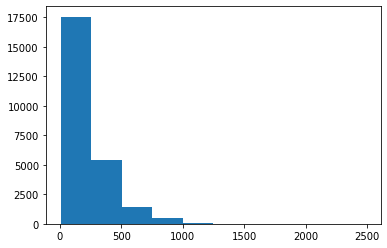

In [9]:
# check freq distribution of review length - 500 and less is majority
review_len =np.zeros(len(train_review))
for i,r in enumerate(train_review):
  review_len[i] = len(r.split())
plt.hist(review_len)

In [10]:
# PAD sentence less than padding number of words with '<PAD>' at beginning and truncate sentence to padding number of words to the end
padding = 500
train_review = [' '.join(['<PAD>'] * (padding - len(r.split())) + r.split()  if len(r.split())<padding else r.split()[:padding]) \
                  for r in train_review]
test_review = [' '.join(['<PAD>'] * (padding - len(r.split())) + r.split()  if len(r.split())<padding else r.split()[:padding]) \
                  for r in test_review]

In [11]:
# create counter of words in the review
counter = Counter(' '.join(train_review+test_review).split())
len(counter)

123052

In [12]:
# import embedding vectors (corresponding to words) from TorchText and vocabulary linking counter words (through embedding word) to embedding vectors 
embedding_FastText = torchtext.vocab.FastText('simple')
vocab=torchtext.vocab.Vocab(counter,vectors=embedding_FastText)
vocab.vectors.shape

torch.Size([123054, 300])

In [13]:
# test vocabulary
sample_word = 'surprising'
print(f'Word "{vocab.itos[vocab.stoi[sample_word]]}" has token={vocab.stoi[sample_word]} with a frequency of {vocab.freqs[sample_word]}')
print(f'Embedding value: {vocab.vectors[vocab.stoi[sample_word]][:20]}')

Word "surprising" has token=1684 with a frequency of 573
Embedding value: tensor([ 0.1460,  0.1829,  0.4267, -0.0951, -0.0146,  0.0448,  0.1046,  0.1308,
        -0.1314, -0.2110, -0.1629, -0.0711, -0.3632, -0.0465, -0.2496, -0.2060,
        -0.3353,  0.0837,  0.1147, -0.1099])


In [14]:
# create embedding layer with pre-trained embedding vectors
embedding = torch.nn.Embedding.from_pretrained(vocab.vectors,freeze=False)
embedding(torch.LongTensor([vocab.stoi[sample_word]])).squeeze()[:20]

tensor([ 0.1460,  0.1829,  0.4267, -0.0951, -0.0146,  0.0448,  0.1046,  0.1308,
        -0.1314, -0.2110, -0.1629, -0.0711, -0.3632, -0.0465, -0.2496, -0.2060,
        -0.3353,  0.0837,  0.1147, -0.1099], grad_fn=<SliceBackward>)

In [15]:
# convert processed text reviews to numpy array of tokens using the above created vocabulary
train_x = np.array([[vocab.stoi[w] for w in r.split()] for r in train_review])
test_x = np.array([[vocab.stoi[w] for w in r.split()] for r in test_review])

In [16]:
from torch.utils.data import TensorDataset, DataLoader
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x),torch.from_numpy(train_y))
test_data = TensorDataset(torch.from_numpy(test_x),torch.from_numpy(test_y))
# create batches using data loader
batch_size = 50
train_loader = DataLoader(train_data,shuffle=True,batch_size=batch_size)
test_loader = DataLoader(test_data,shuffle=False,batch_size=batch_size)

In [17]:
# test dataloader
dataiter = iter(train_loader)
sample_x,sample_y = dataiter.next()
print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([50, 500])
Sample input: 
 tensor([[ 1445, 20873, 15707,  ...,  7002,  6376,   109],
        [    2,     2,     2,  ...,    34,  5169,   174],
        [    2,     2,     2,  ...,  2537,    12, 10136],
        ...,
        [    2,     2,     2,  ...,     9,     7,   124],
        [    2,     2,     2,  ...,     9,    53,  1396],
        [    2,     2,     2,  ...,    19,    22,  1393]])
Sample label size:  torch.Size([50])
Sample label: 
 tensor([0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0,
        0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0,
        0, 1])


In [18]:
class rnn_model(nn.Module):
  def __init__(self,embedding_dim,hidden_dim,output_dim,lstm_layers,drop_prob=0.5):
    super(rnn_model,self).__init__()
    self.hidden_dim = hidden_dim
    self.output_dim = output_dim
    self.lstm_layers = lstm_layers
    
    self.embeddings = nn.Embedding.from_pretrained(vocab.vectors,freeze=False)
    self.rnn = nn.GRU(embedding_dim,hidden_dim,lstm_layers,batch_first=True,dropout=drop_prob)
    self.fc = nn.Linear(hidden_dim,output_dim)
    self.sigmoid = nn.Sigmoid()

  def forward(self,x,hidden):
    batch_size = x.size(0)
    x = self.embeddings(x.long())
    out_rnn, hidden = self.rnn(x,hidden)
    out = self.fc(out_rnn.contiguous().view(-1,self.hidden_dim))
    out = self.sigmoid(out)
    out = out.view(batch_size,-1,self.output_dim)
    out = out[:,-1]
    
    return out,hidden
  
  def init_hidden(self,batch_size):
    hidden = (torch.zeros(self.lstm_layers,batch_size,self.hidden_dim))

    return hidden


In [19]:
# define the RNN model
model = rnn_model(300,100,1,1)
print(model)

# loss and optimization functions
lr = 0.0001
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=lr)

rnn_model(
  (embeddings): Embedding(123054, 300)
  (rnn): GRU(300, 100, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [20]:
# train the model and show loss, accuracy
batch_size=50
n_epochs = 5
check_accuracy = 100
if cuda:
  model = model.cuda()
model.train()

for e in range(n_epochs):
  hidden = model.init_hidden(batch_size)
  if cuda:
    hidden = hidden.cuda()
  for i, (inputs,labels) in enumerate(train_loader,1):
    if cuda:
      inputs, labels = inputs.cuda(), labels.cuda()
    hidden = hidden.data
    optimizer.zero_grad()
    outputs, hidden = model(inputs,hidden)
    loss = loss_function(outputs.squeeze(),labels.float())
    loss.backward()
    optimizer.step()
  
    if (i % check_accuracy) == 0:
      val_losses = []
      n_correct = 0
      val_hidden = model.init_hidden(batch_size)
      if cuda:
        val_hidden = val_hidden.cuda()
      model.eval()
      for (val_inputs, val_labels) in test_loader:
        val_hidden = val_hidden.data
        if cuda:
          val_inputs,val_labels = val_inputs.cuda(),val_labels.cuda()
        val_outputs,val_hidden = model(val_inputs,val_hidden)
        val_loss = loss_function(val_outputs.squeeze(),val_labels.float())
        val_losses.append(val_loss.item())
        preds = torch.round(val_outputs.squeeze())
        correct_preds = preds.eq(val_labels.float().view_as(preds))
        n_correct += np.sum(correct_preds.cpu().numpy().squeeze() if cuda else correct_preds.squeeze())
      
      model.train()

      print(f'Epoch:{e+1}/{n_epochs} - batch: {i}; training loss = {loss.item()}; validation loss = {np.mean(val_losses)}; valuation accuracy = {n_correct/len(test_data)}')
      

Epoch:1/5 - batch: 100; training loss = 0.6799650192260742; validation loss = 0.6864913156032563; valuation accuracy = 0.57092
Epoch:1/5 - batch: 200; training loss = 0.6692885160446167; validation loss = 0.6793058961629868; valuation accuracy = 0.60048
Epoch:1/5 - batch: 300; training loss = 0.6602709889411926; validation loss = 0.6647820892333984; valuation accuracy = 0.6324
Epoch:1/5 - batch: 400; training loss = 0.5516782402992249; validation loss = 0.5755315380096435; valuation accuracy = 0.71796
Epoch:1/5 - batch: 500; training loss = 0.443349689245224; validation loss = 0.4691941105425358; valuation accuracy = 0.78616
Epoch:2/5 - batch: 100; training loss = 0.4974810779094696; validation loss = 0.44836271145939827; valuation accuracy = 0.8022
Epoch:2/5 - batch: 200; training loss = 0.4577566087245941; validation loss = 0.419461524784565; valuation accuracy = 0.81336
Epoch:2/5 - batch: 300; training loss = 0.35988372564315796; validation loss = 0.4089549657702446; valuation accur